In [2]:
# importing all the required libraries.
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model


In [3]:
# importing the dataset and just analysing it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Unzipping the folder
!unzip -uq "/content/drive/My Drive/Faceexpdata3_1.zip" 

In [5]:
train_dir = "/content/Faceexpdata3_1/train_1/"
test_dir = "/content/Faceexpdata3_1/test_1/"

In [6]:
row, col = 48, 48
classes = 4

In [7]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       neutral  angry   sad  happy
train     4965   3995  4830   7215
      neutral  angry   sad  happy
test     1233    958  1247   1774


In [8]:
# creating training and testing sets
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, horizontal_flip=True)
training_set = train_datagen.flow_from_directory(train_dir, batch_size=128, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical')

Found 21005 images belonging to 4 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir, batch_size=128, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical')

Found 5212 images belonging to 4 classes.


In [10]:
# training_set.class_indices - angry-0, happy-1, neutral-2, sad-3.

# defining model
def get_model(input_size, classes=4):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    # model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
fernet = get_model((row,col,1), classes)
# fernet.summary() - this actually prints the summary like model type, layer types added, etc.

In [12]:
chk_path = '/content/ferNet2.h5'
log_dir = "/content/checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,save_best_only=True,verbose=1,mode='auto',moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# training the model

In [15]:

steps_per_epoch = len(training_set)
validation_steps = len(test_set)

hist = fernet.fit(x=training_set, validation_data=test_set, epochs= 20, callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
165/165 [==============================] - 19s 114ms/step - loss: 0.9110 - accuracy: 0.6705 - val_loss: 0.9228 - val_accuracy: 0.6681

Epoch 00001: val_loss improved from 0.94092 to 0.92281, saving model to /content/ferNet2.h5
Epoch 2/20
165/165 [==============================] - 19s 114ms/step - loss: 0.8939 - accuracy: 0.6778 - val_loss: 0.9389 - val_accuracy: 0.6637

Epoch 00002: val_loss did not improve from 0.92281
Epoch 3/20
165/165 [==============================] - 19s 114ms/step - loss: 0.8996 - accuracy: 0.6781 - val_loss: 1.0477 - val_accuracy: 0.6113

Epoch 00003: val_loss did not improve from 0.92281
Epoch 4/20
165/165 [==============================] - 19s 113ms/step - loss: 0.9094 - accuracy: 0.6734 - val_loss: 0.9658 - val_accuracy: 0.6447

Epoch 00004: val_loss did not improve from 0.92281
Epoch 5/20
165/165 [==============================] - 18s 112ms/step - loss: 0.8993 - accuracy: 0.6790 - val_loss: 0.9284 - val_accuracy: 0.6646

Epoch 00005: val_loss did

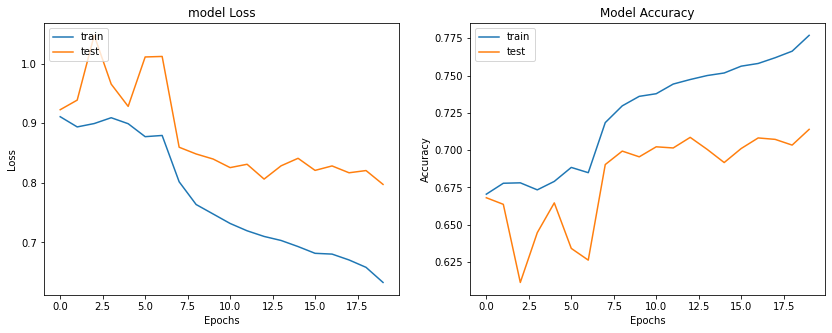

In [16]:
# loss and accuracy plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()